In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import seaborn as sns

In [27]:
path = "C:/Users/Deep/Downloads/European soccer matches/dataset.sqlite"

In [28]:
con= sqlite3.connect(path)

In [29]:
total_number_of_matches = pd.read_sql_query("SELECT count(*) as Total_matches from match", con)
total_number_of_matches

,Total_matches
0,25979


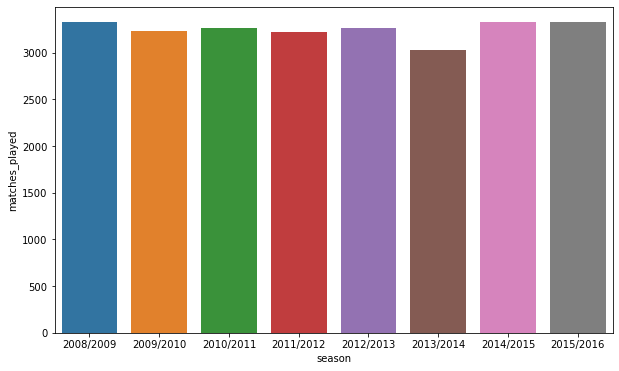

In [17]:
matches_per_season = pd.read_sql_query("SELECT season, count(*) matches_played\
                        from match\
                        group by season", con)
plt.figure(figsize = (10,6))
sns.barplot(x = 'season', y = 'matches_played', data = matches_per_season);

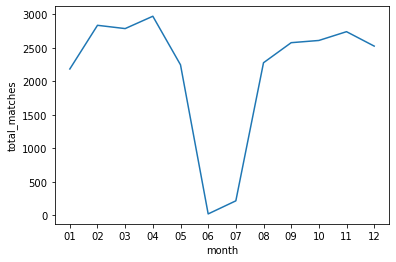

In [18]:
# Matches played each month


matches_per_month = pd.read_sql_query("select strftime('%m', date) as month, count(*) as total_matches\
                                        from Match\
                                        group by month\
                                        order by month", con)
sns.lineplot(x='month', y = 'total_matches' , data = matches_per_month);

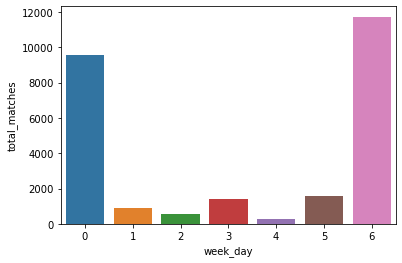

In [19]:
# Matches played each day

matches_per_day = pd.read_sql_query("select strftime('%w', date) as week_day, count(*) as total_matches\
                                    from Match\
                                    group by week_day\
                                    order by week_day", con)
sns.barplot(x = 'week_day', y = 'total_matches', data = matches_per_day);


In [20]:
# maximum Stages of each league with respect to season

max_stages = pd.read_sql_query("SELECT \
                                l.name || ' (' || c.name  || ')' as Name,\
                                m.season, max(m.stage) as Stage\
                            FROM \
                               Match as m\
                                JOIN COUNTRY as c\
                                ON c.id = m.country_id\
                                JOIN League as l\
                                ON l.id = m.league_id\
                                JOIN Team as t\
                                on t.team_api_id = m.home_team_api_id\
                            group by c.name, m.season", con)
max_stages.head(8)

,Name,season,Stage
0,Belgium Jupiler League (Belgium),2008/2009,34
1,Belgium Jupiler League (Belgium),2009/2010,30
2,Belgium Jupiler League (Belgium),2010/2011,30
3,Belgium Jupiler League (Belgium),2011/2012,30
4,Belgium Jupiler League (Belgium),2012/2013,30
5,Belgium Jupiler League (Belgium),2013/2014,6
6,Belgium Jupiler League (Belgium),2014/2015,30
7,Belgium Jupiler League (Belgium),2015/2016,30


In [21]:
# those teams which played in leagues matches so far

country_league = pd.read_sql_query("select \
                                            DISTINCT m.home_team_api_id,\
                                            t.team_long_name,\
                                            c.name as country_name,\
                                            l.name as League_name\
                                        from \
                                            Country as c join match as m\
                                            on c.id = m.country_id\
                                            JOIN League as l\
                                            ON l.id = m.league_id\
                                            join Team as t\
                                            on m.home_team_api_id = t.team_api_id\
                                        order by country_name, League_name, t.team_long_name", con)
country_league.head()

,home_team_api_id,team_long_name,country_name,League_name
0,9993,Beerschot AC,Belgium,Belgium Jupiler League
1,8342,Club Brugge KV,Belgium,Belgium Jupiler League
2,7947,FCV Dender EH,Belgium,Belgium Jupiler League
3,9991,KAA Gent,Belgium,Belgium Jupiler League
4,6351,KAS Eupen,Belgium,Belgium Jupiler League


<AxesSubplot:xlabel='name', ylabel='WINS'>

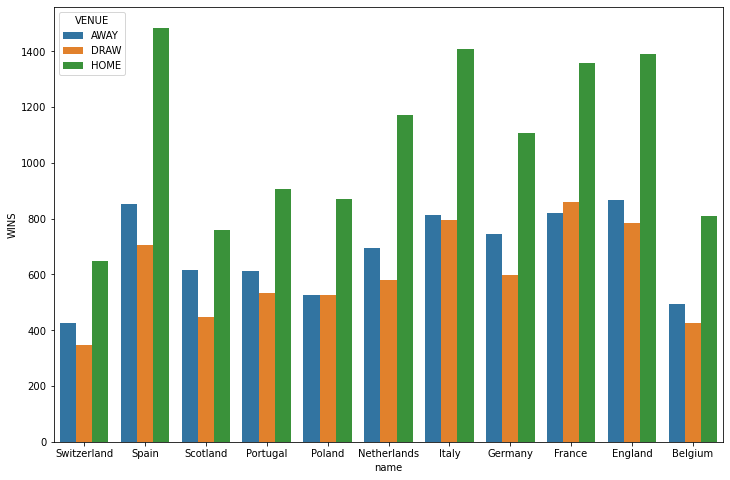

In [22]:
# is it true that teams perform better on home ground.


away_home_win = pd.read_sql_query("SELECT \
                        c.name,\
                        case when m.home_team_goal > m.away_team_goal Then 'HOME'\
                        when m.home_team_goal < m.away_team_goal Then 'AWAY'\
                        else 'DRAW' end as VENUE,\
                        count(*) as WINS\
                    FROM\
                        Match as m\
                        join Country as c\
                        on c.id = m.country_id\
                    group by c.name, VENUE\
                    order by c.name desc", con)

plt.figure(figsize = (12,8))
sns.barplot(x = 'name', y = 'WINS', data = away_home_win, hue = 'VENUE' )

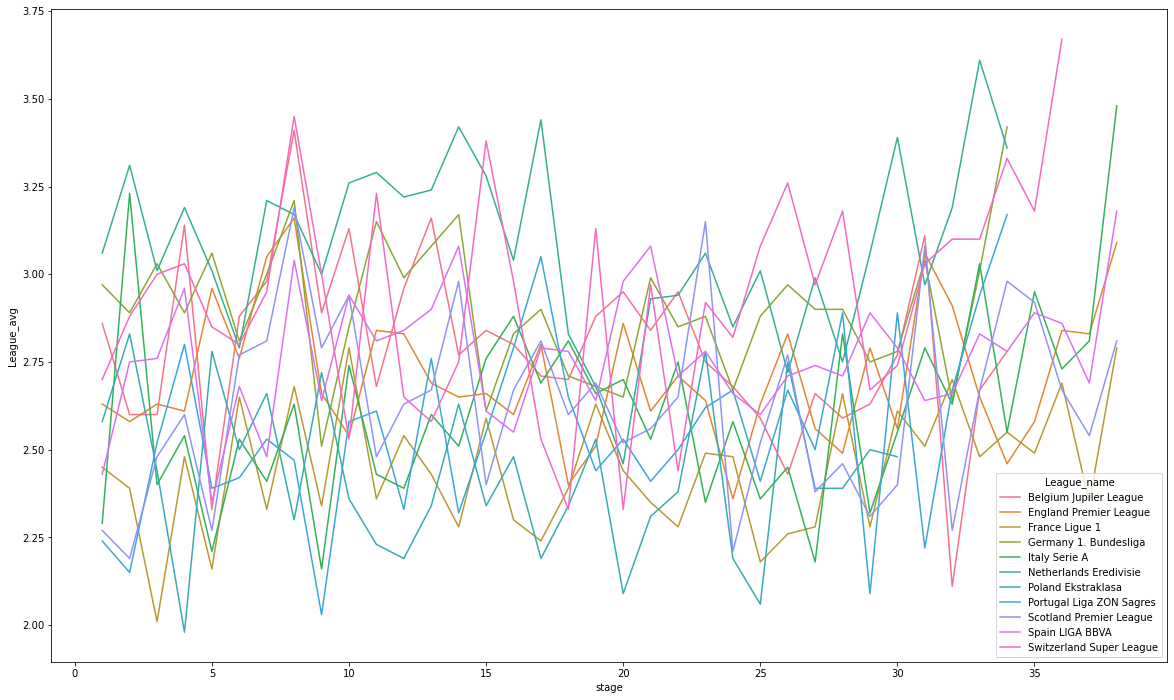

In [23]:
# average goals of a game on basis of group stages. 


league_avg = pd.read_sql_query("select \
                        l.name as League_name,\
                        m.stage,\
                        round(avg(m.away_team_goal + m.home_team_goal),2) as League_avg,\
                        round((select avg(away_team_goal + home_team_goal) from Match),2) as Overall\
                    from match as m\
                        join League as l\
                        on l.id = m.country_id\
                    group by l.name, m.stage\
                    order by stage", con)
plt.figure(figsize = (20 , 12))
sns.lineplot(x = 'stage', y = 'League_avg', hue = 'League_name', data = league_avg);

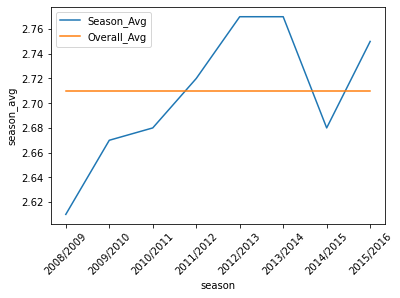

In [24]:
# comparing overall average season goal games with each season.

season_avg = pd.read_sql_query("select \
                          season,\
                          round(avg(away_team_goal + home_team_goal),2) as season_avg,\
                          round((select avg(away_team_goal + home_team_goal) from Match),2) as Overall\
                    from\
                          match\
                          group by season\
                          order by season", con)


sns.lineplot(x = 'season', y = 'season_avg', data = season_avg)
sns.lineplot(x = 'season', y = 'Overall',   data = season_avg)
plt.legend(labels=["Season_Avg","Overall_Avg"])
plt.xticks(rotation = 45);

In [33]:
    # total wins by a team.



    team_wins = pd.read_sql_query("with home as ( select \
            t.team_long_name,\
            count(home_team_goal > away_team_goal) as Home_win\
        from\
            match as m\
            join team as t\
            on m.home_team_api_id = t.team_api_id\
        where \
            m.home_team_goal > m.away_team_goal\
        group by t.team_long_name\
        order by Home_win desc),\
    away as (\
        select \
            t.team_long_name,\
            count(home_team_goal < away_team_goal) as Away_win\
        from\
            match as m\
            join team as t\
            on m.away_team_api_id = t.team_api_id\
        where \
            m.home_team_goal < m.away_team_goal\
        group by t.team_long_name\
        order by Away_win desc)\
    select \
        away.team_long_name,\
        away.away_win,\
        home.home_win,\
        (away.away_win + home.home_win) as total_win\
        from away \
        join home \
        on away.team_long_name = home.team_long_name\
        order by total_win desc", con)

    team_wins

,team_long_name,Away_win,Home_win,total_win
0,FC Barcelona,103,131,234
1,Real Madrid CF,99,129,228
2,Celtic,98,120,218
3,FC Bayern Munich,84,109,193
4,Manchester United,76,116,192
...,...,...,...,...
290,FC Penafiel,2,3,5
291,DSC Arminia Bielefeld,2,2,4
292,FC Dordrecht,1,3,4
293,Córdoba CF,2,1,3
